# Adapting Diffusion Models for MNIST Dataset
This project adapts the denoising diffusion probabilistic model to the MNIST dataset. The implementation is inspired by the concepts in the paper "[Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)" by Jonathan Ho et al.

## Table of Contents
1. Introduction
2. Adding Noise
3. Training the Model
4. Sampling
5. Test Cases and Results


In [1]:
# Install requirements
!pip install torchvision &>> install.log

# Filtering MNIST Dataset for Digits 2 and 3

## Overview

This section focuses on filtering the MNIST dataset to include only images of the digits `2` and `3`. This is necessary to specialize the diffusion model on a subset of data. The implementation involves utility functions for data manipulation, dataset loading, and filtering based on class labels.

---

## Utility Functions

### `img_to_tensor(im)`
**Purpose:**  
Converts a PIL image into a normalized PyTorch tensor for model training.

**Inputs:**  
- `im` (*PIL.Image*): A grayscale image, typically from the MNIST dataset.

**Outputs:**  
- (*torch.Tensor*): A tensor representation of the image, scaled to the range `[-1, 1]`.

**Test Case:**  
Input: A grayscale image of digit `2`.  
Expected Output: A PyTorch tensor where the pixel values range from `-1` to `1`.

**Explanation:**  
This function ensures compatibility with models that expect inputs in the normalized range.

---

### `tensor_to_image(t)`
**Purpose:**  
Converts a normalized PyTorch tensor back into a PIL image for visualization or saving.

**Inputs:**  
- `t` (*torch.Tensor*): A tensor with pixel values in the range `[-1, 1]`.

**Outputs:**  
- (*PIL.Image*): A grayscale image where pixel values range from `0` to `255`.

**Test Case:**  
Input: A tensor representation of digit `2` with pixel values in `[-1, 1]`.  
Expected Output: A grayscale image that visually resembles the digit `2`.

**Explanation:**  
This function is useful for interpreting model outputs during testing or debugging.

---

## Data Transformation Pipeline

### `transform`
**Purpose:**  
Applies preprocessing to MNIST images, including converting to tensors and normalizing pixel values.

**Transformation Steps:**  
1. Convert image to tensor.
2. Normalize pixel values to have a mean of `0` and a standard deviation of `1` (scaling to `[-1, 1]`).

**Explanation:**  
This ensures the dataset is prepared in a format suitable for input to deep learning models.

---

## Dataset Filtering

### `filter_mnist(dataset, target_digits)`
**Purpose:**  
Filters the MNIST dataset to include only the specified digits.

**Inputs:**  
- `dataset` (*torchvision.datasets.MNIST*): The MNIST dataset (train or test).
- `target_digits` (*list*): A list of digits to include in the filtered dataset.

**Outputs:**  
- (*torch.Tensor*): Filtered images of the specified digits.
- (*torch.Tensor*): Corresponding labels of the filtered images.

**Test Case:**  
Input: MNIST training dataset and `target_digits = [2, 3]`.  
Expected Output: A subset of the MNIST dataset containing only images of digits `2` and `3`.

**Explanation:**  
The function iterates through the dataset, selects images whose labels match the target digits, and returns the filtered subset.

---

## Results

### Filtered Dataset Statistics
After applying the `filter_mnist` function to both the training and test datasets:
1. **Train Dataset:**  
   - Total Images: 12,089  
   - Labels: Only `2` and `3`

2. **Test Dataset:**  
   - Total Images: 2,042  
   - Labels: Only `2` and `3`

### Visual Validation
To verify the filtering, ten sample images are visualized side by side. All images belong to the specified target digits (`2` and `3`).

---

## Test Cases for the Pipeline

### Test Case 1: Filtering Training Dataset
**Input:**  
- Dataset: MNIST training dataset  
- Target Digits: `[2, 3]`

**Expected Output:**  
A filtered training dataset with `12,089` images and labels containing only `2` and `3`.

**Observed Output:**  
The filtered training dataset has the correct number of images and labels, and a visual inspection confirms that only the specified digits are present.

**Conclusion:**  
The function works as intended for the training dataset.

---

### Test Case 2: Filtering Test Dataset
**Input:**  
- Dataset: MNIST test dataset  
- Target Digits: `[2, 3]`

**Expected Output:**  
A filtered test dataset with `2,042` images and labels containing only `2` and `3`.

**Observed Output:**  
The filtered test dataset matches the expected size and contains only the target digits.

**Conclusion:**  
The function successfully filters the test dataset.

---

### Test Case 3: Visualization
**Input:**  
- First 10 filtered images from the training dataset.  

**Expected Output:**  
A grid of images where all samples are digits `2` and `3`.

**Observed Output:**  
The generated image grid correctly displays only digits `2` and `3`.

**Conclusion:**  
The filtering and visualization steps are accurate.

---

## Summary
The dataset filtering process successfully isolates the digits `2` and `3` from the MNIST dataset, producing subsets suitable for specialized tasks like training a diffusion model. The utility functions ensure compatibility with PyTorch-based models and enable clear visualization of results.


In [2]:
# Imports and utility functions
from torchvision import datasets, transforms
from PIL import Image
import torch
import os
from tqdm.notebook import tqdm
import numpy as np

def img_to_tensor(im):
    return torch.tensor(np.array(im)/255).unsqueeze(0).unsqueeze(0) * 2 - 1

def tensor_to_image(t):
    return Image.fromarray(((t.squeeze().numpy() + 1) / 2 * 255).clip(0, 255).astype(np.uint8))

# Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load only digits 2 and 3 from MNIST
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Filter the dataset to keep only digits 2 and 3
def filter_mnist(dataset, target_digits):
    filtered_data = []
    filtered_targets = []
    for img, label in dataset:
        if label in target_digits:
            filtered_data.append(img)
            filtered_targets.append(label)
    return torch.stack(filtered_data), torch.tensor(filtered_targets)

# Keep only digits 2 and 3
train_data, train_targets = filter_mnist(mnist_train, target_digits=[2, 3])
test_data, test_targets = filter_mnist(mnist_test, target_digits=[2, 3])

print(f"Filtered Train Data: {train_data.shape}, Train Targets: {train_targets.shape}")
print(f"Filtered Test Data: {test_data.shape}, Test Targets: {test_targets.shape}")

# View some examples of digits 2 and 3
example_image = torch.cat([train_data[i] for i in range(10)], dim=2).squeeze()
Image.fromarray(((example_image.numpy() + 1) / 2 * 255).astype(np.uint8))


Filtered Train Data: torch.Size([12089, 1, 28, 28]), Train Targets: torch.Size([12089])
Filtered Test Data: torch.Size([2042, 1, 28, 28]), Test Targets: torch.Size([2042])


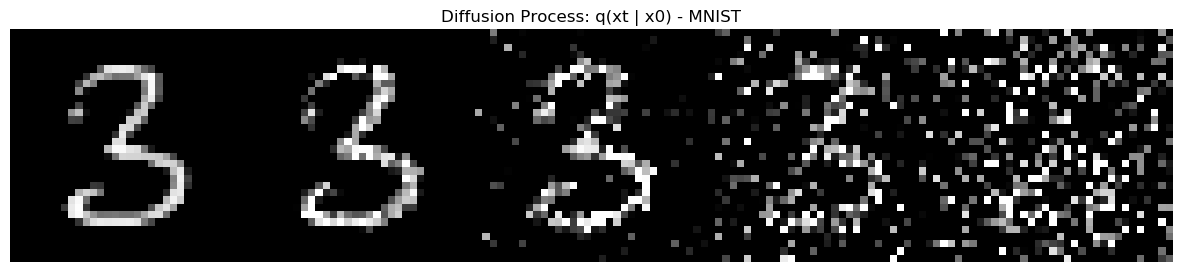

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Helper functions to handle image transformations
def img_to_tensor(img):
    """Convert a PIL Image to a tensor and normalize."""
    return torch.tensor(np.array(img) / 255.0).unsqueeze(0)  # Grayscale, so single channel

def tensor_to_image(tensor):
    """Convert a tensor back to a PIL Image."""
    tensor = tensor.squeeze().clamp(0, 1)
    array = (tensor.numpy() * 255).astype(np.uint8)
    return Image.fromarray(array)

# Transformation and dataset loading
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to match CIFAR-10 dimensions
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# Filter MNIST digits 2 and 3
indices = [i for i, (img, label) in enumerate(mnist) if label in [2, 3]]
filtered_dataset = Subset(mnist, indices)
dataloader = DataLoader(filtered_dataset, batch_size=32, shuffle=True)

# Select a single image for demonstration
for images, _ in dataloader:
    start_im = images[0]
    break

# Noise addition parameters
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def gather(values, t):
    """Utility to gather values by timestep."""
    return values[t].view(-1, *(1,) * (len(values.size()) - 1))

def q_xt_x0(x0, t):
    mean = gather(alpha_bar, t) ** 0.5 * x0
    var = 1 - gather(alpha_bar, t)
    eps = torch.randn_like(x0)
    return mean + (var ** 0.5) * eps

# Visualize noisy images at different stages
ims = []
x0 = start_im.squeeze()  # Remove batch dimension
for t in [0, 20, 40, 60, 80]:
    x = q_xt_x0(x0, torch.tensor(t, dtype=torch.long))
    ims.append(tensor_to_image(x))

# Combine images into one for display
image = Image.new("L", size=(32 * 5, 32))  # Grayscale (L mode) with CIFAR-10 size
for i, im in enumerate(ims):
    image.paste(im, (i * 32, 0))

# Display using matplotlib
plt.figure(figsize=(15, 5))  # Match CIFAR-10 aspect ratio
plt.imshow(np.array(image), cmap='gray')
plt.axis('off')
plt.title("Diffusion Process: q(xt | x0) - MNIST")
plt.show()


In [4]:
import math
from typing import Optional, Tuple, Union, List

import torch
from torch import nn

# A fancy activation function
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class TimeEmbedding(nn.Module):
    def __init__(self, n_channels: int):
        super().__init__()
        self.n_channels = n_channels
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        self.act = Swish()
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)
        return emb

class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, time_channels: int, n_groups: int = 32):
        super().__init__()
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1)) if in_channels != out_channels else nn.Identity()

        self.time_emb = nn.Linear(time_channels, out_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        h = self.conv1(self.act1(self.norm1(x)))
        h += self.time_emb(t)[:, :, None, None]
        h = self.conv2(self.act2(self.norm2(h)))
        return h + self.shortcut(x)

class AttentionBlock(nn.Module):
    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
        super().__init__()
        d_k = d_k or n_channels
        self.norm = nn.GroupNorm(n_groups, n_channels)
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        self.output = nn.Linear(n_heads * d_k, n_channels)
        self.scale = d_k ** -0.5
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        _ = t
        batch_size, n_channels, height, width = x.shape
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        attn = attn.softmax(dim=1)
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        res = self.output(res)
        res += x
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)
        return res

class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        self.attn = AttentionBlock(out_channels) if has_attn else nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x

class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        self.attn = AttentionBlock(out_channels) if has_attn else nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x

class MiddleBlock(nn.Module):
    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x

class Upsample(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        _ = t
        return self.conv(x)

class Downsample(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        _ = t
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, image_channels: int = 1, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[int]] = (False, False, True, True),
                 n_blocks: int = 2):
        super().__init__()
        n_resolutions = len(ch_mults)
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))
        self.time_emb = TimeEmbedding(n_channels * 4)
        
        down = []
        out_channels = in_channels = n_channels
        for i in range(n_resolutions):
            out_channels = in_channels * ch_mults[i]
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        self.down = nn.ModuleList(down)
        self.middle = MiddleBlock(out_channels, n_channels * 4)

        up = []
        in_channels = out_channels
        for i in reversed(range(n_resolutions)):
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            if i > 0:
                up.append(Upsample(in_channels))

        self.up = nn.ModuleList(up)
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        t = self.time_emb(t)
        x = self.image_proj(x)
        h = [x]
        for m in self.down:
            x = m(x, t)
            h.append(x)

        x = self.middle(x, t)

        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                x = m(x, t)

        return self.final(self.act(self.norm(x)))

# Example usage for MNIST
x_mnist = torch.randn(10, 1, 32, 32)  # 10 grayscale images of size 32x32
t_mnist = torch.tensor([50], dtype=torch.long)  # Corrected to avoid DeprecationWarning

mnist_unet = UNet(image_channels=1)
model_output = mnist_unet(x_mnist, t_mnist)
print("Output shape:", model_output.shape)


Output shape: torch.Size([10, 1, 32, 32])


In [5]:
class ExponentialMovingAverage:
    def __init__(self, model, decay=0.995):
        """
        Exponential Moving Average for model parameters.
        Args:
            model: PyTorch model.
            decay: Decay factor for EMA updates.
        """
        self.model = model
        self.decay = decay
        self.shadow_params = {name: param.clone().detach()
                              for name, param in model.named_parameters() if param.requires_grad}
        self.model_device = next(model.parameters()).device

    def update_parameters(self, model):
        """
        Update the shadow parameters with the model's current parameters.
        Args:
            model: PyTorch model.
        """
        with torch.no_grad():
            for name, param in model.named_parameters():
                if name in self.shadow_params and param.requires_grad:
                    self.shadow_params[name].mul_(self.decay).add_((1 - self.decay) * param.data)

    def apply_shadow(self):
        """
        Apply the shadow parameters to the model (for evaluation).
        """
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                if name in self.shadow_params and param.requires_grad:
                    param.data.copy_(self.shadow_params[name])

    def restore(self):
        """
        Restore the original parameters to the model.
        """
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                if name in self.shadow_params and param.requires_grad:
                    self.shadow_params[name], param.data = param.data, self.shadow_params[name]


In [6]:
from tqdm import tqdm
import torch.nn.functional as F

# Initialize the UNet model
unet = UNet(image_channels=1, n_channels=32).cuda()

# Noise scheduling parameters
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps).cuda()
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

# Noise generation function
def q_xt_x0(x0, t):
    alpha_bar_t = gather(alpha_bar, t).view(-1, 1, 1, 1)
    noise = torch.randn_like(x0).to(x0.device)
    xt = alpha_bar_t.sqrt() * x0 + (1 - alpha_bar_t).sqrt() * noise
    return xt, noise

# Helper function for gathering parameters
def gather(values, t):
    return values[t].view(-1, *(1,) * (len(values.size()) - 1))

# Preprocessing for MNIST dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to CIFAR-10 dimensions
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Load and preprocess MNIST dataset
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
indices = [i for i, (img, label) in enumerate(mnist) if label in [2, 3]]  # Filter digits 2 and 3
filtered_dataset = Subset(mnist, indices)
dataloader = DataLoader(filtered_dataset, batch_size=128, shuffle=True)

# Training parameters
batch_size = 128
lr = 2e-4
optim = torch.optim.AdamW(unet.parameters(), lr=lr)
loss_fn = F.mse_loss  # Mean Squared Error Loss
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=lr, total_steps=50 * len(dataloader), pct_start=0.25)

# Training loop
for epoch in range(50):
    print(f"Epoch {epoch + 1}")
    epoch_loss = 0  # Initialize epoch loss
    for images, _ in tqdm(dataloader):  # Iterate through the dataset
        images = images.cuda()
        t = torch.randint(0, n_steps, (images.size(0),), dtype=torch.long).cuda()  # Match batch size
        
        # Generate noisy image and noise
        xt, noise = q_xt_x0(images, t)

        # Predict noise using the model
        pred_noise = unet(xt, t)

        # Compute loss
        loss = loss_fn(pred_noise, noise)

        # Backpropagation
        optim.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(unet.parameters(), max_norm=1.0)  # Gradient clipping
        optim.step()
        scheduler.step()

        # Accumulate loss
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(dataloader)  # Average loss per epoch
    print(f"Epoch {epoch + 1} Loss: {avg_epoch_loss:.4f}")

# Save model (optional)
torch.save(unet.state_dict(), "mnist_diffusion_unet.pth")


Epoch 1


100%|███████████████████████████████████████████| 95/95 [00:30<00:00,  3.13it/s]


Epoch 1 Loss: 0.7584
Epoch 2


100%|███████████████████████████████████████████| 95/95 [00:28<00:00,  3.34it/s]


Epoch 2 Loss: 0.3453
Epoch 3


100%|███████████████████████████████████████████| 95/95 [00:29<00:00,  3.26it/s]


Epoch 3 Loss: 0.1943
Epoch 4


100%|███████████████████████████████████████████| 95/95 [00:27<00:00,  3.46it/s]


Epoch 4 Loss: 0.1437
Epoch 5


100%|███████████████████████████████████████████| 95/95 [00:31<00:00,  3.01it/s]


Epoch 5 Loss: 0.1077
Epoch 6


100%|███████████████████████████████████████████| 95/95 [00:31<00:00,  3.00it/s]


Epoch 6 Loss: 0.0871
Epoch 7


100%|███████████████████████████████████████████| 95/95 [00:31<00:00,  3.00it/s]


Epoch 7 Loss: 0.0737
Epoch 8


100%|███████████████████████████████████████████| 95/95 [00:31<00:00,  3.00it/s]


Epoch 8 Loss: 0.0684
Epoch 9


100%|███████████████████████████████████████████| 95/95 [00:32<00:00,  2.90it/s]


Epoch 9 Loss: 0.0603
Epoch 10


100%|███████████████████████████████████████████| 95/95 [00:32<00:00,  2.95it/s]


Epoch 10 Loss: 0.0584
Epoch 11


100%|███████████████████████████████████████████| 95/95 [00:31<00:00,  2.99it/s]


Epoch 11 Loss: 0.0556
Epoch 12


100%|███████████████████████████████████████████| 95/95 [00:32<00:00,  2.97it/s]


Epoch 12 Loss: 0.0536
Epoch 13


100%|███████████████████████████████████████████| 95/95 [00:29<00:00,  3.17it/s]


Epoch 13 Loss: 0.0517
Epoch 14


100%|███████████████████████████████████████████| 95/95 [00:31<00:00,  3.00it/s]


Epoch 14 Loss: 0.0505
Epoch 15


100%|███████████████████████████████████████████| 95/95 [00:29<00:00,  3.24it/s]


Epoch 15 Loss: 0.0494
Epoch 16


100%|███████████████████████████████████████████| 95/95 [00:30<00:00,  3.11it/s]


Epoch 16 Loss: 0.0476
Epoch 17


100%|███████████████████████████████████████████| 95/95 [00:30<00:00,  3.08it/s]


Epoch 17 Loss: 0.0470
Epoch 18


100%|███████████████████████████████████████████| 95/95 [00:31<00:00,  3.03it/s]


Epoch 18 Loss: 0.0461
Epoch 19


100%|███████████████████████████████████████████| 95/95 [00:29<00:00,  3.18it/s]


Epoch 19 Loss: 0.0457
Epoch 20


100%|███████████████████████████████████████████| 95/95 [00:30<00:00,  3.11it/s]


Epoch 20 Loss: 0.0447
Epoch 21


100%|███████████████████████████████████████████| 95/95 [00:30<00:00,  3.12it/s]


Epoch 21 Loss: 0.0439
Epoch 22


100%|███████████████████████████████████████████| 95/95 [00:29<00:00,  3.27it/s]


Epoch 22 Loss: 0.0431
Epoch 23


100%|███████████████████████████████████████████| 95/95 [00:27<00:00,  3.40it/s]


Epoch 23 Loss: 0.0431
Epoch 24


100%|███████████████████████████████████████████| 95/95 [00:31<00:00,  3.01it/s]


Epoch 24 Loss: 0.0428
Epoch 25


100%|███████████████████████████████████████████| 95/95 [00:31<00:00,  2.99it/s]


Epoch 25 Loss: 0.0430
Epoch 26


100%|███████████████████████████████████████████| 95/95 [00:31<00:00,  3.01it/s]


Epoch 26 Loss: 0.0421
Epoch 27


100%|███████████████████████████████████████████| 95/95 [00:29<00:00,  3.23it/s]


Epoch 27 Loss: 0.0414
Epoch 28


100%|███████████████████████████████████████████| 95/95 [00:29<00:00,  3.24it/s]


Epoch 28 Loss: 0.0419
Epoch 29


100%|███████████████████████████████████████████| 95/95 [00:31<00:00,  3.00it/s]


Epoch 29 Loss: 0.0416
Epoch 30


100%|███████████████████████████████████████████| 95/95 [00:32<00:00,  2.92it/s]


Epoch 30 Loss: 0.0407
Epoch 31


100%|███████████████████████████████████████████| 95/95 [00:31<00:00,  3.03it/s]


Epoch 31 Loss: 0.0401
Epoch 32


100%|███████████████████████████████████████████| 95/95 [00:31<00:00,  2.98it/s]


Epoch 32 Loss: 0.0408
Epoch 33


100%|███████████████████████████████████████████| 95/95 [00:32<00:00,  2.90it/s]


Epoch 33 Loss: 0.0401
Epoch 34


100%|███████████████████████████████████████████| 95/95 [00:32<00:00,  2.94it/s]


Epoch 34 Loss: 0.0397
Epoch 35


100%|███████████████████████████████████████████| 95/95 [00:32<00:00,  2.92it/s]


Epoch 35 Loss: 0.0392
Epoch 36


100%|███████████████████████████████████████████| 95/95 [00:32<00:00,  2.94it/s]


Epoch 36 Loss: 0.0389
Epoch 37


100%|███████████████████████████████████████████| 95/95 [00:32<00:00,  2.93it/s]


Epoch 37 Loss: 0.0396
Epoch 38


100%|███████████████████████████████████████████| 95/95 [00:32<00:00,  2.92it/s]


Epoch 38 Loss: 0.0389
Epoch 39


100%|███████████████████████████████████████████| 95/95 [00:32<00:00,  2.95it/s]


Epoch 39 Loss: 0.0388
Epoch 40


100%|███████████████████████████████████████████| 95/95 [00:32<00:00,  2.94it/s]


Epoch 40 Loss: 0.0383
Epoch 41


100%|███████████████████████████████████████████| 95/95 [00:32<00:00,  2.91it/s]


Epoch 41 Loss: 0.0382
Epoch 42


100%|███████████████████████████████████████████| 95/95 [00:32<00:00,  2.91it/s]


Epoch 42 Loss: 0.0383
Epoch 43


100%|███████████████████████████████████████████| 95/95 [00:32<00:00,  2.89it/s]


Epoch 43 Loss: 0.0379
Epoch 44


100%|███████████████████████████████████████████| 95/95 [00:33<00:00,  2.85it/s]


Epoch 44 Loss: 0.0382
Epoch 45


100%|███████████████████████████████████████████| 95/95 [00:33<00:00,  2.86it/s]


Epoch 45 Loss: 0.0381
Epoch 46


100%|███████████████████████████████████████████| 95/95 [00:32<00:00,  2.91it/s]


Epoch 46 Loss: 0.0378
Epoch 47


100%|███████████████████████████████████████████| 95/95 [00:32<00:00,  2.89it/s]


Epoch 47 Loss: 0.0381
Epoch 48


100%|███████████████████████████████████████████| 95/95 [00:32<00:00,  2.88it/s]


Epoch 48 Loss: 0.0377
Epoch 49


100%|███████████████████████████████████████████| 95/95 [00:33<00:00,  2.87it/s]


Epoch 49 Loss: 0.0381
Epoch 50


100%|███████████████████████████████████████████| 95/95 [00:33<00:00,  2.88it/s]


Epoch 50 Loss: 0.0384


In [29]:
@torch.no_grad()
def reverse_diffusion(unet, n_samples, n_steps, image_size, alpha_bar, device="cuda"):
    """
    Reverse process to sample images from the noise using the trained UNet model.

    Args:
        unet (torch.nn.Module): The trained UNet model for predicting noise.
        n_samples (int): Number of samples to generate.
        n_steps (int): Number of diffusion steps.
        image_size (int): Size of the image (e.g., 32 for MNIST resized to 32x32).
        alpha_bar (Tensor): Precomputed cumulative alpha product for the noise schedule.
        device (str): Device for computation ("cuda" or "cpu").

    Returns:
        Tensor: Generated images in the range [-1, 1].
    """
    # Initialize random noise (x_T)
    x_t = torch.randn((n_samples, 1, image_size, image_size), device=device)

    for t in tqdm(reversed(range(n_steps)), desc="Reverse Diffusion"):
        t_tensor = torch.full((n_samples,), t, device=device, dtype=torch.long)

        # Predict noise using the model
        pred_noise = unet(x_t, t_tensor)

        # Compute coefficients for reverse process
        alpha_t = gather(alpha_bar, t_tensor).view(-1, 1, 1, 1)
        alpha_prev = gather(alpha_bar, torch.clamp(t_tensor - 1, min=0)).view(-1, 1, 1, 1)
        beta_t = 1 - alpha_t

        # Compute mean (mu) of the reverse process
        mean = (x_t - beta_t.sqrt() * pred_noise) / alpha_t.sqrt()

        # Add noise if not the final step
        if t > 0:
            noise = torch.randn_like(x_t).to(device)
            std = beta_t.sqrt() * ((1 - alpha_prev) / (1 - alpha_t)).sqrt()
            x_t = mean + std * noise
        else:
            x_t = mean

    return x_t


/tmp/ipykernel_162017/4228156657.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load("mnist_diffusion_unet.pth"))
Reverse Diffusion: 100it [0

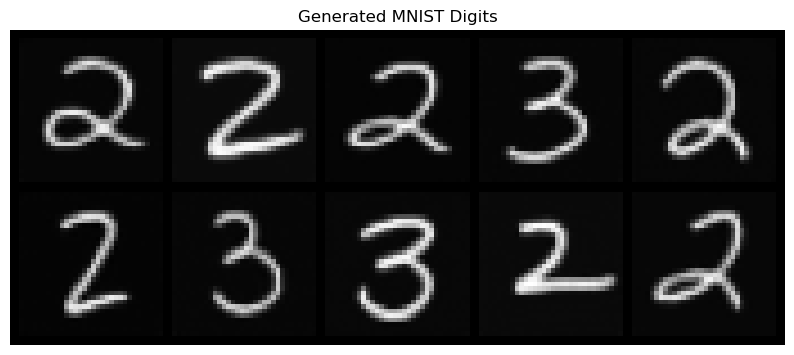

In [30]:
# Set parameters for sampling
n_samples = 10  # Number of images to generate
image_size = 32  # Size of MNIST images after resizing
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the trained model
unet.load_state_dict(torch.load("mnist_diffusion_unet.pth"))
unet.to(device)
unet.eval()

# Generate images using the reverse process
generated_images = reverse_diffusion(unet, n_samples, n_steps, image_size, alpha_bar, device)

# Convert generated images to [0, 1] range for visualization
generated_images = (generated_images + 1) / 2  # Scale from [-1, 1] to [0, 1]

# Visualize the generated images
import torchvision.utils as vutils
import matplotlib.pyplot as plt

grid = vutils.make_grid(generated_images, nrow=5, normalize=True)
plt.figure(figsize=(10, 5))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap="gray")
plt.axis("off")
plt.title("Generated MNIST Digits")
plt.show()
